In [193]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import v2
import torch.utils.data as dataloader
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [194]:
PROJECT_NAME = 'mlp_cifar10_pytorch'
PROJECT_ENTITY = 'cs20b013-bersilin'

# Labels for the CIFAR-10 dataset

LABELS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [195]:
# Create transform to a CIFAR image to a tensor of type float32

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [196]:
# Loading the CIFAR-10 dataset

def load_data(transform: v2.Compose):
    '''
    Load the CIFAR-10 dataset
    '''
    train_data = datasets.CIFAR10(root='./data', 
                                  train=True,
                                  download=True, 
                                  transform=transform)

    test_data = datasets.CIFAR10(root='./data',
                                 train=False,
                                 download=True,
                                 transform=transform)

    return train_data, test_data

# Split the training set into a training and validation set

def val_split(train_data, split=0.2, shuffle=True):
    '''
    Split the training set into a training and validation set

    Args:
    train_set: the training set
    split: the proportion of the validation set
    shuffle: whether to shuffle the indices before splitting
    '''
    train_size = len(train_data)
    indices = list(range(train_size))
    split = int(np.floor(split * train_size))

    if shuffle:
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]
    train_set = dataloader.Subset(train_data, train_indices)
    val_set = dataloader.Subset(train_data, val_indices)

    return train_set, val_set

# Create a dataloader

def create_dataloader(train_set, val_set, test_set, batch_size):
    '''
    Create a dataloader for the training and test sets
    '''
    train_loader = dataloader.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = dataloader.DataLoader(val_set, batch_size=5 * batch_size, shuffle=False)
    test_loader = dataloader.DataLoader(test_set, batch_size=5 * batch_size, shuffle=False)

    return train_loader, val_loader, test_loader
        

In [197]:
# print size of all the sets passed

def print_info(train_set, val_set, test_set):
    '''
    Print the size of the training, validation and test sets
    '''
    print(f"Training set: {len(train_set)}")
    print(f"Validation set: {len(val_set)}")
    print(f"Test set: {len(test_set)}")

In [198]:
# Show a random image from the dataset

def show_random_image(dataset: datasets.CIFAR10, index: int = None):
    '''
    Shows a random image from the dataset
    '''
    if index is None:
        index = torch.randint(0, len(dataset), (1,)).item()
    else:
        index = index
                
    image, label = dataset[index]
    plt.imshow(image.permute(1, 2, 0)) # change the shape from (3, 32, 32) to (32, 32, 3)
    plt.title(LABELS[label])
    plt.show()

    return index, label

In [199]:
def plot_confusion_matrix(y_true, y_pred):
    '''
    Plot the confusion matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS.values())
    disp.plot(cmap='Blues', xticks_rotation='vertical')

In [200]:
def plot_accuracies(train_acc, val_acc):
    '''
    Plot the training and validation accuracies
    '''
    plt.plot(train_acc, label='Training accuracy')
    plt.plot(val_acc, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [201]:
# Architecture of the model

class MLP(nn.Module):
    def __init__(self, device):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(32 * 32 * 3, 500, device=device)
        self.fc2 = nn.Linear(500, 250, device=device)
        self.fc3 = nn.Linear(250, 100, device=device)
        self.fc4 = nn.Linear(100, 10, device=device)

        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = x.view(-1, 32 * 32 * 3) # Flatten the input tensor

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        
        x = self.softmax(self.fc4(x))
        return x

In [202]:
def get_accuracy(model, data_loader):
    '''
    Get the accuracy of the model on the data_loader
    '''
    correct, total = 0, 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    return correct / total

In [203]:
# Training the model

def train(configs,
          train_loader: dataloader.DataLoader,
          val_loader: dataloader.DataLoader,
          criterion: nn.Module,
          optimizer: optim.Optimizer,
          model: nn.Module):
    
    if configs['wandb_log']:
        import wandb
        run = wandb.init(project=PROJECT_NAME, entity=PROJECT_ENTITY, config=configs)
        run.name = f"lr={configs['learning_rate']}_bs={configs['batch_size']}_epochs={configs['num_epochs']}"
        wandb.watch(model, criterion, log='all')

    print('Training the model...')
    print('---------------------')

    val_accuracies, train_accuracies = [], []

    for epoch in range(configs['num_epochs']):
        model.train()
        running_loss = 0.0

        total_iterations = len(train_loader)

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            # change labels to one-hot encoding
            # labels = nn.functional.one_hot(labels, num_classes=10).float()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i != total_iterations-1):
                print(f'Epoch {epoch + 1}, Iteration {i + 1}/{total_iterations}, Loss: {loss.item()}', end='\r')
            else:
                print(f'Epoch {epoch + 1}, Iteration {i + 1}/{total_iterations}, Loss: {loss.item()}')

        print(f'Epoch {epoch + 1} done, Training Loss: {running_loss / len(train_loader)}')

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f'Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_loader)}')

        train_accuracy = get_accuracy(model, train_loader)
        val_accuracy = get_accuracy(model, val_loader)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy} \n')

        if configs['wandb_log']:
            wandb.log({'Epoch:': epoch + 1,
                       'Training Loss': running_loss / len(train_loader),
                       'Validation Loss': val_loss / len(val_loader),
                       'Training Accuracy': train_accuracy,
                       'Validation Accuracy': val_accuracy})

    print('Finished Training')

    if configs['wandb_log']:
        wandb.finish()
    
    return model, configs, train_accuracies, val_accuracies

In [204]:
def get_predicted_labels(model, data_loader):
    '''
    Get the predicted labels of the model on the data_loader
    '''
    predicted_labels = []
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            predicted_labels.append(predicted)

    assert len(predicted_labels) == len(data_loader) # Check if all the data has been processed

    predicted_labels = torch.cat(predicted_labels, dim=0)

    assert(predicted_labels.size(0) == len(data_loader.dataset)) # Check if the size of the predicted labels is equal to the size of the dataset

    return predicted_labels.to('cpu').numpy()

In [207]:
# Configuration

configs = {
    'batch_size': 100,
    'learning_rate': 0.07,
    'num_epochs': 10,
    'momentum': 0.9,

    'wandb_log': True,
    'batch_norm': False
}

In [205]:
train_set, test_set = load_data(transform)
train_set, val_set = val_split(train_set)
train_loader, val_loader, test_loader = create_dataloader(train_set, val_set, test_set, configs['batch_size'])

print_info(train_set, val_set, test_set)

Files already downloaded and verified
Files already downloaded and verified
Training set: 40000
Validation set: 10000
Test set: 10000


The size of one image is:  torch.Size([3, 32, 32])
The label of the first image is:  deer


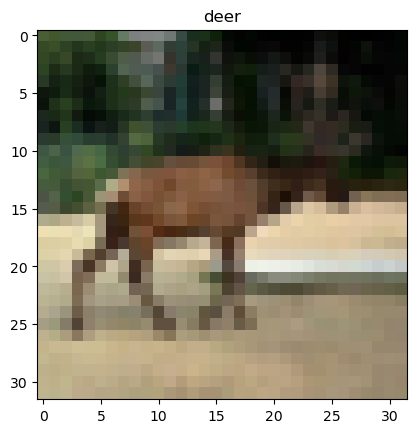

In [206]:
print("The size of one image is: ", train_set[0][0].size())
print("The label of the first image is: ", LABELS[train_set[0][1]])
index, label = show_random_image(train_set, 0)

In [208]:
model = MLP(device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=configs['learning_rate'], momentum=configs['momentum'])

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training the model...
---------------------
Epoch 1, Iteration 400/400, Loss: 2.2412285804748535
Epoch 1 done, Training Loss: 2.2331958025693894
Epoch 1, Validation Loss: 2.1804721474647524
Epoch 1, Training Accuracy: 0.27025, Validation Accuracy: 0.2699 

Epoch 2, Iteration 400/400, Loss: 2.1718397140502936
Epoch 2 done, Training Loss: 2.1570284593105318
Epoch 2, Validation Loss: 2.1809128642082216
Epoch 2, Training Accuracy: 0.270525, Validation Accuracy: 0.2677 

Epoch 3, Iteration 400/400, Loss: 2.1467511653900146
Epoch 3 done, Training Loss: 2.131913797259331
Epoch 3, Validation Loss: 2.1607643961906433
Epoch 3, Training Accuracy: 0.29695, Validation Accuracy: 0.2917 

Epoch 4, Iteration 400/400, Loss: 2.1665320396423342
Epoch 4 done, Training Loss: 2.1156960198283197
Epoch 4, Validation Loss: 2.119715654850006
Epoch 4, Training Accuracy: 0.335575, Validation Accuracy: 0.3331 

Epoch 5, Iteration 400/400, Loss: 2.1563749313354494
Epoch 5 done, Training Loss: 2.1163526746630668
Epo

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch:,▁▂▃▃▄▅▆▆▇█
Training Accuracy,▁▁▃▅▅▄▇▇█▇
Training Loss,█▄▃▂▂▂▁▂▁▁
Validation Accuracy,▁▁▃▅▅▄▆▇█▇
Validation Loss,██▇▄▄▅▃▂▁▂
Epoch:,10
Training Accuracy,0.36515
Training Loss,2.09898
Validation Accuracy,0.3639
Validation Loss,2.09134


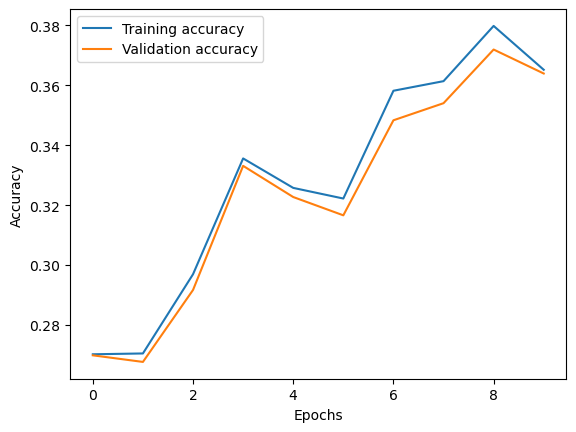

In [209]:
model, configs, train_accuracies, val_accuracies = train(configs, train_loader, val_loader, criterion, optimizer, model)
plot_accuracies(train_accuracies, val_accuracies)

Test Accuracy: 0.3548


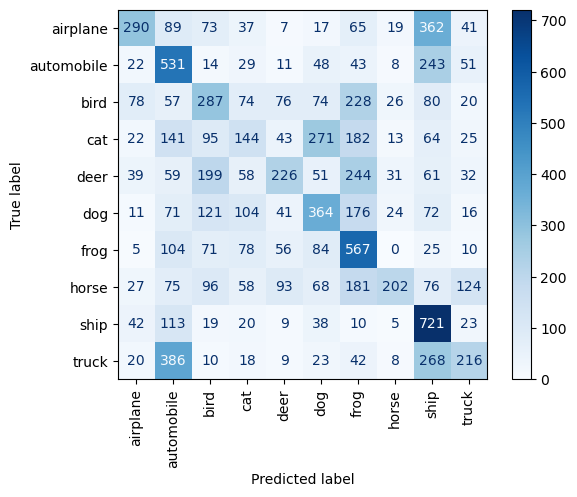

In [210]:
test_accuracy = get_accuracy(model, test_loader)
print(f'Test Accuracy: {test_accuracy}')

predicted_y = get_predicted_labels(model, test_loader)
true_y = torch.tensor(test_loader.dataset.targets).to('cpu').numpy()

plot_confusion_matrix(true_y, predicted_y)

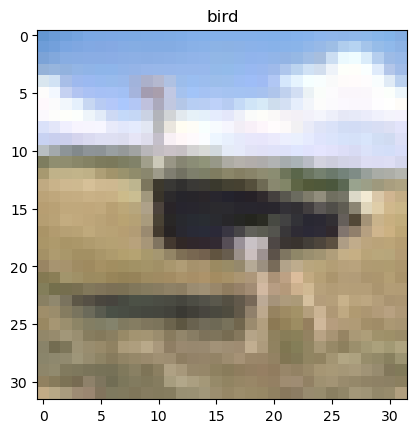

The true label is: bird
The predicted label is: airplane


In [211]:
index, label = show_random_image(test_set)

print(f'The true label is: {LABELS[label]}')
print(f'The predicted label is: {LABELS[predicted_y[index]]}')